# Stock Forecasting using Transformers

In this notebook we implement a Transformer model to forecast stock data.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413

In [2]:
import glob
import logging
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
import sys
import tensorflow as tf
import tensorflow.keras as keras

In [3]:
sns.set() # Use seaborn themes.

## Environment Setup

This section contains code that is modifies output path locations, random seed, and logging.

In [4]:
DATASET_ROOT = Path('~/ml/datasets').expanduser()
if not DATASET_ROOT.exists(): raise ValueError(f"Dataset root directory does not exist at {DATASET_ROOT}")

In [5]:
# Set random seeds.
SEED = 0
tf.random.set_seed(SEED) # Only this works on ARC (since tensorflow==2.4).

In [6]:
# Setup logging (useful for ARC systems).
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG) # Must be lowest of all handlers listed below.
while logger.hasHandlers(): logger.removeHandler(logger.handlers[0]) # Clear all existing handlers.

# Custom log formatting.
formatter = logging.Formatter('%(asctime)s | %(levelname)s | %(message)s')

# Log to STDOUT (uses default formatting).
sh = logging.StreamHandler(stream=sys.stdout)
sh.setLevel(logging.INFO)
logger.addHandler(sh)

# Set Tensorflow logging level.
tf.get_logger().setLevel('ERROR') # 'INFO'

In [7]:
# Request user for Kaggle login if JSON file does not exist.
kaggle_config_file = Path("~/.kaggle/kaggle.json").expanduser()
if not kaggle_config_file.exists() and os.environ.get("KAGGLE_USERNAME", None) is None and os.environ.get("KAGGLE_KEY", None) is None:
    import json
    import getpass
    entry = getpass.getpass(prompt="Please enter your Kaggle username or JSON blob: ")
    try:
        blob = json.loads(entry)
        os.environ["KAGGLE_USERNAME"] = blob['username']
        os.environ["KAGGLE_KEY"] = blob['key']
    except:
        api_key = getpass.getpass(prompt="Please enter your Kaggle API KEY: ")
        os.environ["KAGGLE_USERNAME"] = entry
        os.environ["KAGGLE_KEY"] = api_key
else:
    logger.info('Kaggle API configured')

Kaggle API configured


In [8]:
# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
logger.info(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    logger.info(f"Name: {gpu.name}, Type: {gpu.device_type}")

Num GPUs Available: 0


## Huge Stock Market Dataset from Kaggle

https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

In [9]:
class HugeStockMarketDataset:
    """Wrapper for Huge Stock Market Dataset by Boris Marjanovic on Kaggle.

    Source URL is: https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/version/3

    This class can be used like a Python dictionary, where keys are the stock/etf names, and values are
    `pandas.DataFrame` objects corresponding to that stock/etf.
    """
    root = 'HugeStockMarketDataset'

    def __init__(self, 
        path: str,
        files: list = None,
        quiet: bool = False,
        exclude_stocks: bool = False,
        exclude_etfs: bool = False,
        usecols: list[str] = ['Date','Open','High','Low','Close','Volume','OpenInt'],
        ):
        self.exclude_stocks = exclude_stocks
        self.exclude_etfs = exclude_etfs
        self.usecols = usecols
        self._index = {}

        # Download the dataset if necessary.
        newpath = Path(path).expanduser()/self.root
        if not newpath.exists():
            self.download(newpath, files, quiet=quiet)
        else:
            self.path = newpath
            self._build_index()

    def _build_index(self):
        """Creates an internal index of stocks and ETFs for lookup."""

        # Helper function to index a folder of files.
        def _index_folder(dir: Path):
            for file in glob.iglob(str(dir/'*.txt'), recursive=True):
                filename = Path(file).name
                product_name = filename.split('.', maxsplit=1)[0]
                self._index[product_name] = file

        # Index all stocks.
        if not self.exclude_stocks:
            _index_folder(self.path/'Stocks')
        
        # Index all ETFs.
        if not self.exclude_etfs:
            _index_folder(self.path/'ETFs')

    def download(self, path: str, files: list = None, quiet: bool = True):
        """Downloads the dataset from Kaggle.

        Args:
            path (str): The path to place the download.
            files (list, optional): Subset list of files to download instead of entire dataset. Defaults to None.
            quiet (bool, optional): Suppress verbose output. Defaults to True.
        """
        import kaggle
        kaggle_dataset = 'borismarjanovic/price-volume-data-for-all-us-stocks-etfs'
        kaggle.api.authenticate()

        # Save the new downloaded path.
        self.path = Path(path).expanduser()

        # Specific file list was given.
        if files is not None:
            for f in files:
                kaggle.api.dataset_download_file(
                    dataset=kaggle_dataset,
                    file_name=f,
                    path=path/f,
                    quiet=quiet,
                )
        # Download all files.
        else:
            kaggle.api.dataset_download_files(
                dataset=kaggle_dataset,
                path=path,
                unzip=True,
                quiet=quiet,
            )

        # Force rebuild the index after downloading.
        logger.info("Building file index")
        self._build_index()

    def get_dataframe(self, 
        key: str,
        **kwargs,
        ) -> pd.DataFrame:
        """Obtain historical data for stock or ETF in a pandas dataframe.

        Optional keyword arguments are passed directly to `pandas.read_csv` function.

        Args:
            key (str): The identifier for the stock or ETF.

        Returns:
            pd.DataFrame: Historical data.
        """
        return pd.read_csv(self._index[key], **kwargs)

    #### Dictionary Override ######

    def __getitem__(self, key):
        if isinstance(key, str):
            return self.get_dataframe(key, usecols=self.usecols)
        elif isinstance(key, list):
            return [self.get_dataframe(asset, usecols=self.usecols) for asset in key]

    def __delitem__(self, key):
        del self._index[key]

    def __iter__(self):
        return iter(self._index)

    def items(self):
        for key in self:
            yield key, self.get_dataframe(key, usecols=self.usecols)

    def __len__(self):
        return len(self._index)

    def keys(self):
        """Returns a list of all downloaded stocks and ETFs."""
        return self._index.keys()

    ###############################

Now lets actually load the dataset. In this case, we're only looking at the `aapl` stock.

In [10]:
dataset = HugeStockMarketDataset(DATASET_ROOT, usecols=['Date','Open','High','Low','Close','Volume'])
asset = 'aapl'
df = dataset[asset]
df.tail()

,Date,Open,High,Low,Close,Volume
8359,2017-11-06,171.75,174.36,171.10,173.63,34901241
8360,2017-11-07,173.29,174.51,173.29,174.18,24424877
8361,2017-11-08,174.03,175.61,173.71,175.61,24451166
8362,2017-11-09,174.48,175.46,172.52,175.25,29533086
8363,2017-11-10,175.11,175.38,174.27,174.67,25130494


Plot the closing price and volume for the chosen stock.

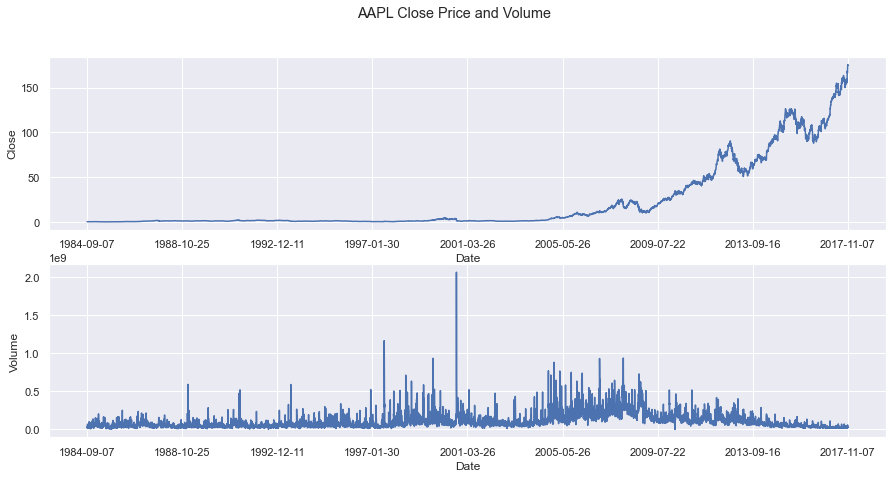

In [11]:
fig = plt.figure(figsize=(15,7))
fig.suptitle(f'{asset.upper()} Close Price and Volume')

n = len(df.index)//8 # Number of date record ticks on X-axis.

ax = fig.add_subplot(211)
sns.lineplot(x='Date', y='Close', data=df, ax=ax)
ax.set_xticks(range(0, df.shape[0], n))
ax.set_xticklabels(df['Date'].loc[::n])

ax = fig.add_subplot(212)
sns.lineplot(x='Date', y='Volume', data=df, ax=ax)
ax.set_xticks(range(0, df.shape[0], n))
ax.set_xticklabels(df['Date'].loc[::n]);

In [12]:
a = df[['Open','High','Low','Close','Volume']].to_numpy()
t = tf.convert_to_tensor(a)

In [13]:
import numpy as np
np.arange(len(df.index) - (128 + 1) + 1)

array([   0,    1,    2, ..., 8233, 8234, 8235])

In [51]:
# Inspiration: https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing
class WindowGenerator:
    def __init__(self,
        in_seq_len: int,
        out_seq_len: int,
        shift: int,
        train_df: pd.DataFrame,
        val_df: pd.DataFrame,
        test_df: pd.DataFrame,
        in_feat: list[str] = None,
        out_feat: list[str] = None,
        ):
        """Constructs sliding windows of sequential data.

        Data must already be split into train/val/test subsets,
        and provided as `pandas.DataFrame` objects.

        Args:
            in_seq_len (int): Input sequence length.
            out_seq_len (int): Output (target) sequence length.
            shift (int): Number of indices to skip between elements when traversing window.
            train_df (pd.DataFrame): Training data frame.
            val_df (pd.DataFrame): Validation data frame.
            test_df (pd.DataFrame): Testing data frame.
            in_feat (list[str], optional): Desired subset of input features for window. Defaults to None.
            out_feat (list[str], optional): Desired subset of output features for window. Defaults to None.
        """

        # Preserve dataframes.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Preserve sequence information.
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.shift = shift
        self.total_window_len = in_seq_len + shift

        # Setup indexing slices for window extraction.
        self.in_slice = slice(0, self.in_seq_len)
        self.out_slice = slice(self.total_window_len - self.out_seq_len, None)
        self.in_idx = np.arange(self.total_window_len)[self.in_slice]
        self.out_idx = np.arange(self.total_window_len)[self.out_slice]

        # Setup train/val/test column extractors.
        self.col2idx = {name: i for i, name in enumerate(train_df.columns)}
        if in_feat is not None:
            self.in_feat = in_feat
            self.in_col_idx = [self.col2idx[col] for col in in_feat]
        else:
            self.in_col_idx = list(range(len(train_df.columns)))
            self.in_feat = [train_df.columns[i] for i in self.in_col_idx]
        if out_feat is not None:
            self.out_feat = out_feat
            self.out_col_idx = [self.col2idx[col] for col in out_feat]
        else:
            self.out_col_idx = list(range(len(train_df.columns)))
            self.out_feat = [train_df.columns[i] for i in self.out_col_idx]

    def __repr__(self):
        return '\n'.join([
            f"Total window length: {self.total_window_len}",
            f"Input indices: {self.in_idx}",
            f"Output indices: {self.out_idx}",
            f"Input features: {self.in_feat}",
            f"Output features: {self.out_feat}",
        ])

    def split_window(self, 
        window: tf.Tensor, # window shape is (batch, seq, feat)
        ) -> tuple[tf.Tensor, tf.Tensor]:
        # Decompose input/output sequence from given input window.
        in_seq = tf.stack([window[:, self.in_slice, i] for i in self.in_col_idx], axis=-1)
        out_seq = tf.stack([window[:, self.out_slice, i] for i in self.out_col_idx], axis=-1)

        # Set shape for input/output sequences.
        # Note that dimensions set to `None` are not updated.
        in_seq = tf.ensure_shape(in_seq, (None, self.in_seq_len, None))
        out_seq = tf.ensure_shape(out_seq, (None, self.out_seq_len, None))

        return in_seq, out_seq


    def make_dataset(self, 
        df: pd.DataFrame,
        batch_size: int = 32,
        shuffle: bool = True,
        ) -> tf.data.Dataset:
        """Construct a TensorFlow Dataset from given input data frame.

        Args:
            df (pd.DataFrame): Source data frame.
            batch_size (int, optional): Batch size. Defaults to 32.
            shuffle (bool, optional): Shuffle windows prior to batching. Defaults to True.

        Returns:
            tf.data.Dataset: _description_
        """

        # Convert data frame into numpy matrix.
        data = df.to_numpy()

        # Convert data matrix into TensorFlow dataset.
        dataset = keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_len,
            sequence_stride=self.shift,
            shuffle=shuffle,
            batch_size=batch_size,
        )

        # Pipe the raw dataset into the window splitting function.
        dataset = dataset.map(self.split_window)

        # Return the dataset.
        return dataset

    @property
    def train(self):
        return self.make_dataset(
            df=self.train_df,
        )

    @property
    def val(self):
        return self.make_dataset(
            df=self.val_df,
        )

    @property
    def test(self):
        return self.make_dataset(
            df=self.test_df,
        )

In [63]:
def load_stock_dataset(
    asset: str,
    in_seq_len: int,
    out_seq_len: int,
    shift: int,
    split: tuple[float, float, float], # must sum to 1.
    in_feat: list[str] = ['Open','High','Low','Close','Volume'],
    out_feat: list[str] = ['Open','High','Low','Close','Volume'],
    normalize: bool = True,
    ) -> tuple[pd.DataFrame]:
    np.testing.assert_almost_equal(sum(split), 1., err_msg='Split must sum to 1.')
    train_split, _, test_split = split

    # Get dataframe for desired asset.
    dataset = HugeStockMarketDataset(DATASET_ROOT, usecols=['Open','High','Low','Close','Volume'])
    df = dataset[asset]

    # Split dataframe into train/val/test dataframes.
    # Inspiration: https://www.tensorflow.org/tutorials/structured_data/time_series#split_the_data
    n = len(df.index) # Total number of data records.
    df_train = df[:int(n*train_split)].copy()
    df_val = df[int(n*train_split):int(n*(1-test_split))].copy()
    df_test = df[int(n*(1-test_split)):].copy()

    # Normalize the datasets using train-data statistics.
    # Note that only the training data is used for statistics.
    # Inspiration: https://www.tensorflow.org/tutorials/structured_data/time_series#normalize_the_data
    if normalize:
        train_mean = df_train.mean()
        train_std = df_train.std()
        df_train = (df_train - train_mean)/train_std
        df_val = (df_val - train_mean)/train_std
        df_test = (df_test - train_mean)/train_std

    # Build window generator for datasets.
    w = WindowGenerator(
        in_seq_len=in_seq_len,
        out_seq_len=out_seq_len,
        shift=shift,
        train_df=df_train,
        val_df=df_val,
        test_df=df_test,
        in_feat=in_feat,
        out_feat=out_feat,
    )

    # Extract train/val/test datasets and return.
    return w.train, w.val, w.test



dataset_train, dataset_val, dataset_test = load_stock_dataset(
    asset='aapl',
    in_seq_len=128,
    out_seq_len=1,
    shift=1,
    split=(0.7, 0.2, 0.1),
)
print(f"{dataset_train.element_spec=}")
print(f"{dataset_val.element_spec=}")
print(f"{dataset_test.element_spec=}")

dataset_train.element_spec=(TensorSpec(shape=(None, 128, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float64, name=None))
dataset_val.element_spec=(TensorSpec(shape=(None, 128, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float64, name=None))
dataset_test.element_spec=(TensorSpec(shape=(None, 128, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float64, name=None))


<tf.Tensor: shape=(), dtype=int64, numpy=179>

## Time2Vec Embedding

https://arxiv.org/abs/1907.05321

In [12]:
class Time2Vec(keras.layers.Layer):
    def __init__(self, embed_dim: int, activation: str = 'sin', **kwargs):
        """Vector embedding representation of time.

        Based on the original concept proposed by Kazemi et al., 2019 (https://arxiv.org/abs/1907.05321).

        Args:
            embed_dim (int): Length of the time embedding vector.
            activation (str, optional): Periodic activation function. Possible values are ['sin', 'cos']. Defaults to 'sin'.
        """
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.activation = activation.lower() # Convert to lower-case.

        # Set periodic activation function.
        if self.activation.startswith('sin'):
            self.activation_func = tf.sin
        elif self.activation.startswith('cos'):
            self.activation_func = tf.cos
        else:
            raise ValueError(f'Unsupported periodic activation function "{activation}"')

    def build(self, input_shape: list[int]):

        # Weight and bias term for linear portion (i = 0)
        # of embedding.
        self.w_linear = self.add_weight(
            name='w_linear',
            shape=(input_shape[1], 1,),
            initializer='uniform',
            trainable=True,
        )
        self.b_linear = self.add_weight(
            name='b_linear',
            shape=(input_shape[1], 1,),
            initializer='uniform',
            trainable=True,
        )

        # Weight and bias terms for the periodic
        # portion (1 <= i <= k) of embedding.
        self.w_periodic = self.add_weight(
            name='w_periodic',
            shape=(input_shape[-1], self.embed_dim,),
            initializer='uniform',
            trainable=True,
        )
        self.b_periodic = self.add_weight(
            name='b_periodic',
            shape=(input_shape[1], self.embed_dim,),
            initializer='uniform',
            trainable=True,
        )

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """Embed input into linear and periodic feature components.

        Args:
            x (tf.Tensor): Input tensor with shape (batch_size, sequence_length, feature_size)

        Returns:
            tf.Tensor: Output tensor with shape (batch_size, sequence_length, embed_dim + 1)
        """

        # Linear term (i = 0).
        embed_linear = tf.tensordot(x, self.w_linear, axes=1) + self.b_linear

        # Periodic terms (1 <= i <= k).
        inner = tf.tensordot(x, self.w_periodic, axes=1) + self.b_periodic
        embed_periodic = self.activation_func(inner)

        # Return concatenated linear and periodic features.
        return tf.concat([embed_linear, embed_periodic], axis=-1)

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'activation': self.activation,
        })
        return config

stock_feat = 5
seq_len = 128
embed_dim = 32
inp = keras.Input(shape=(seq_len, stock_feat))
logger.info(f"{inp.shape=}")
x = Time2Vec(embed_dim)(inp)
logger.info(f"{x.shape=}")
x = keras.layers.Concatenate(axis=-1)([inp, x])
logger.info(f"{x.shape=}")

inp.shape=TensorShape([None, 128, 5])
x.shape=TensorShape([None, 128, 33])
x.shape=TensorShape([None, 128, 38])


## Transformer Architecture

https://arxiv.org/abs/1706.03762

### Attention Layers

Currently uses attention layers provided by TensorFlow. See https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention.

### Transformer Encoder Layer

https://www.tensorflow.org/text/tutorials/transformer#encoder_layer

In [15]:
class TransformerEncoderLayer(keras.layers.Layer):
    def __init__(self,
        d_k: int,
        d_v: int,
        n_heads: int,
        d_ff: int,
        dropout: float = 0.0,
        **kwargs,
        ):
        """Transformer encoder layer.

        Based on the original concept proposed by Vaswani et al., 2017 (https://arxiv.org/abs/1706.03762).

        Args:
            d_k (int): Key dimension (also used for Query dimension).
            d_v (int): Value dimension.
            n_heads (int): Number of attention heads.
            d_ff (int): Dimension of the feed forward sublayer.
            dropout (float, optional): Dropout rate. Defaults to 0.0.
        """
        super().__init__(**kwargs)
        self.d_k = d_k # Query and Key have same dimension.
        self.d_v = d_v
        self.n_heads = n_heads # Number of attention heads.
        self.d_ff = d_ff
        self.dropout = dropout

    def build(self, input_shape: tuple[tf.TensorShape,tf.TensorShape,tf.TensorShape]):

        # First sublayer.
        # Multi-head attention with add and norm.
        self.attn_multi = keras.layers.MultiHeadAttention(
            num_heads=self.n_heads,
            key_dim=self.d_k,
            value_dim=self.d_v,
        )
        self.attn_multi._build_from_signature(*input_shape)
        self.attn_dropout = keras.layers.Dropout(rate=self.dropout)
        self.attn_add = keras.layers.Add()
        self.attn_norm = keras.layers.LayerNormalization(epsilon=1e-6)

        # Second sublayer.
        # Feed forward with add and norm.
        d_query_feat = input_shape[0][-1] # Query feature size.
        self.ff_dense_1 = keras.layers.Dense(units=self.d_ff, activation='relu')
        self.ff_dense_2 = keras.layers.Dense(units=d_query_feat)
        self.ff_dropout = keras.layers.Dropout(rate=self.dropout)
        self.ff_add = keras.layers.Add()
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, x: tuple[tf.Tensor,tf.Tensor,tf.Tensor]) -> tf.Tensor:
        """Encode input using multi-head self-attention mechanisms.

        Args:
            x (tf.Tensor): Tuple of Query, Value, and Key tensors. Note that the Key tensor is optional, if omitted the Value tensor will be used for both Key and Value.

        Returns:
            tf.Tensor: Output tensor with shape (batch_size, sequence_length, embed_dim + 1)
        """
        # x = (query, value, key)
        # note that "key" is optional.

        # First, do the attention sublayer.
        x_attn = self.attn_multi(*x) # Unpack input as Query, Value, and optional Key.
        x_attn = self.attn_dropout(x_attn)
        x_attn = self.attn_add([x[0], x_attn]) # (residual) Add Query matrix with result of attention layer.
        x_attn = self.attn_norm(x_attn) # Normalize the residual.

        # Second, do the feed forward sublayer.
        x_ff = self.ff_dense_1(x_attn)
        x_ff = self.ff_dense_2(x_ff)
        x_ff = self.ff_dropout(x_ff)
        x_ff = self.ff_add([x_attn, x_ff])
        x_ff = self.ff_norm(x_ff)

        # Return output of feed forward sublayer.
        return x_ff

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            'n_heads': self.n_heads,
            'd_k': self.d_k,
            'd_v': self.d_v,
            'd_ff': self.d_ff,
            'dropout': self.dropout,
        })
        return config


stock_feat = 5
seq_len = 128
embed_dim = 32
d_k = 512
d_v = 256
n_heads = 8
d_ff = 512
inp = keras.Input(shape=(seq_len, stock_feat))
logger.info(f"{inp.shape=}")
x = Time2Vec(embed_dim)(inp)
logger.info(f"Time2Vec {x.shape=}")
x = keras.layers.Concatenate(axis=-1)([inp, x])
logger.info(f"Concatenate {x.shape=}")
x = TransformerEncoderLayer(d_k, d_v, n_heads, d_ff)([x, x, x])
logger.info(f"TransformerEncoder {x.shape=}")
x = TransformerEncoderLayer(d_k, d_v, n_heads, d_ff)([x, x, x])
logger.info(f"TransformerEncoderLayer {x.shape=}")
x = TransformerEncoderLayer(d_k, d_v, n_heads, d_ff)([x, x, x])
logger.info(f"TransformerEncoderLayer {x.shape=}")
x = keras.layers.GlobalAvgPool1D(data_format='channels_first')(x)
logger.info(f"GlobalAvgPool1D {x.shape=}")

inp.shape=TensorShape([None, 128, 5])
Time2Vec x.shape=TensorShape([None, 128, 33])
Concatenate x.shape=TensorShape([None, 128, 38])
TransformerEncoder x.shape=TensorShape([None, 128, 38])
TransformerEncoderLayer x.shape=TensorShape([None, 128, 38])
TransformerEncoderLayer x.shape=TensorShape([None, 128, 38])
GlobalAvgPool1D x.shape=TensorShape([None, 128])


### Model Definition

In [16]:
def build_model(
    in_seq_len: int,
    in_feat: int,
    out_feat: int,
    fc_units: list[int], # list of fully-connected dimensions before classifier.
    embed_dim: int,
    d_k: int,
    d_v: int,
    n_heads: int,
    d_ff: int,
    dropout: float = 0.0,
    n_encoders: int = 3,
    ):

    # Input sequence of features.
    inp = keras.Input(shape=(in_seq_len, in_feat))
    # Time embedding.
    x = Time2Vec(embed_dim)(inp)
    # Combine input with embedding to form attention input features.
    x = keras.layers.Concatenate(axis=-1)([inp, x])
    # Pass combined featured through cascaded self-attention encoder sublayers.
    for _ in range(n_encoders):
        x = TransformerEncoderLayer(
            d_k=d_k,
            d_v=d_v,
            n_heads=n_heads,
            d_ff=d_ff,
            dropout=dropout,
        )((x, x, x)) # (query, value, key)
    # Downsample to the original sequence dimension.
    x = keras.layers.GlobalAvgPool1D(data_format='channels_first')(x) # shape=(in_seq_len,)
    x = keras.layers.Dropout(rate=dropout)(x)
    # Fully-connected network before classifier.
    for units in fc_units: 
        x = keras.layers.Dense(units=units, activation='relu')(x)
        x = keras.layers.Dropout(rate=dropout)(x)
    # Classifier.
    x = keras.layers.Dense(units=out_feat, activation='linear')(x)

    # Construct model class and return.
    return keras.Model(inputs=inp, outputs=x)


kwargs = dict(
    in_seq_len=128, # Number of days in the past.
    in_feat=5, # Number of features for each day in the past.
    out_feat=3, # Number of features on 1-day horizon.
    fc_units=[64,64],
    embed_dim=32,
    d_k=512,
    d_v=256,
    n_heads=8,
    d_ff=512,
)
model = build_model(**kwargs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 5)]     0           []                               
                                                                                                  
 time2_vec_2 (Time2Vec)         (None, 128, 33)      4512        ['input_3[0][0]']                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 128, 38)      0           ['input_3[0][0]',                
                                                                  'time2_vec_2[0][0]']            
                                                                                                  
 transformer_encoder_layer_3 (T  (None, 128, 38)     516836      ['concatenate_2[0][0]',      